# **IST718 Group 13 Project Code**

# Dataset Installing

In [1]:
%%bash
# Do not change or modify this file
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark

# if [[ ! -f ./Telco-Customer-Churn.csv ]]; then 
#    # download the data file from github and save it in this colab environment instance
#    wget https://raw.githubusercontent.com/YY-CHENG/IST/master/Telco_Customer_Churn.csv 
# fi

  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=ff89ef0ced84ff54a8e2d14af8711a09bdf175c454607c97a4f6884e22322186
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [2]:
from pyspark.sql.functions import col, when
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import FloatType, DoubleType

from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline, feature, clustering
from pyspark.ml.feature import StringIndexer, StringIndexerModel, OneHotEncoder, VectorAssembler, PCA, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier, LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, ClusteringEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.patches as mpatches

%matplotlib inline


In [3]:
spark = SparkSession \
  .builder \
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "12g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","12g")\
  .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [4]:
Telco_Customer_Churn_csv = '/content/drive/My Drive/ist718_data/data_group13/Telco_Customer_Churn.csv'

In [6]:
from google.colab import drive
drive.mount('/content/drive')

# You must use the definitions above to load your data.
#telco_churn_df = pd.read_csv(Telco_Customer_Churn_csv)

telco_churn_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(Telco_Customer_Churn_csv)

Mounted at /content/drive


In [8]:
# Grid search switches
grid_search = False

# Dataset Cleaning

In [9]:
#telco_churn_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load('Telco_Customer_Churn.csv')

# Data type inspection
telco_churn_df.printSchema()

# Data inspection
telco_churn_df.toPandas().head()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Data preprocessing
- Drop customerID
- Data type transform
- There are only 11 missing values in TotalCharges column. This values are actually a blank space in the csv file and are exclusive for customers with zero tenure. It's possible to concluded that they are missing due to the fact that the customer never paied anything to the company. We will impute this missing values with zero.

In [10]:
# Delete customerID and change datatypes 
telco_churn_df = telco_churn_df.drop('customerID')
telco_churn_df = telco_churn_df.withColumn("tenure",col("tenure").cast(DoubleType()))
telco_churn_df = telco_churn_df.withColumn("MonthlyCharges",col("MonthlyCharges").cast(DoubleType()))
telco_churn_df = telco_churn_df.withColumn("TotalCharges",col("TotalCharges").cast(DoubleType()))

# remove NA in TotalCharges
telco_churn_df = telco_churn_df.na.drop()
telco_churn_df = telco_churn_df.withColumn("TotalCharges",col("TotalCharges").cast(DoubleType()))

cat_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
            'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
num_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']

# inspect dataset
telco_churn_df.toPandas().head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45.0,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Statistic Inspections

In [11]:
telco_churn_df.select(num_vars).describe().toPandas()

,summary,tenure,MonthlyCharges,TotalCharges
0,count,7032,7032,7032
1,mean,32.421786120591584,64.79820819112632,2283.3004408418697
2,stddev,24.545259709263245,30.085973884049825,2266.771361883145
3,min,1.0,18.25,18.8
4,max,72.0,118.75,8684.8


In [12]:
telco_churn_df.crosstab("gender", "churn").show()
for col in cat_vars:
  display(telco_churn_df.groupBy(col).count().toPandas())

+------------+----+---+
|gender_churn|  No|Yes|
+------------+----+---+
|        Male|2619|930|
|      Female|2544|939|
+------------+----+---+



,gender,count
0,Female,3483
1,Male,3549


,SeniorCitizen,count
0,1,1142
1,0,5890


,Partner,count
0,No,3639
1,Yes,3393


,Dependents,count
0,No,4933
1,Yes,2099


,PhoneService,count
0,No,680
1,Yes,6352


,MultipleLines,count
0,No phone service,680
1,No,3385
2,Yes,2967


,InternetService,count
0,Fiber optic,3096
1,No,1520
2,DSL,2416


,OnlineSecurity,count
0,No,3497
1,Yes,2015
2,No internet service,1520


,OnlineBackup,count
0,No,3087
1,Yes,2425
2,No internet service,1520


,DeviceProtection,count
0,No,3094
1,Yes,2418
2,No internet service,1520


,TechSupport,count
0,No,3472
1,Yes,2040
2,No internet service,1520


,StreamingTV,count
0,No,2809
1,Yes,2703
2,No internet service,1520


,StreamingMovies,count
0,No,2781
1,Yes,2731
2,No internet service,1520


,Contract,count
0,Month-to-month,3875
1,One year,1472
2,Two year,1685


,PaperlessBilling,count
0,No,2864
1,Yes,4168


,PaymentMethod,count
0,Credit card (automatic),1521
1,Mailed check,1604
2,Bank transfer (automatic),1542
3,Electronic check,2365


# Visualization
- Churn summary
- Distribution
- Line Graphs for Numeric Variables
- Bar Plots for Categorical Variables
- Heatmap
- Pairplot

## Numeric Variables

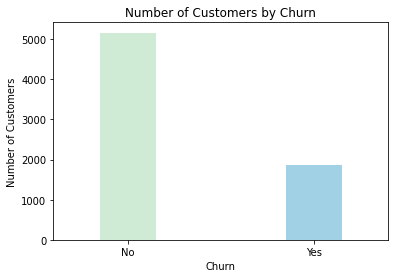

In [13]:
telco_churn_df_pd = telco_churn_df.toPandas()
# check the traget variable
C = telco_churn_df_pd['Churn'].value_counts().plot(kind = 'bar',rot = 0, width = 0.3,color =['#A1D9AD','#42A5CA'], alpha = 0.5)
C.set_ylabel('Number of Customers')
C.set_xlabel('Churn')
C.set_title('Number of Customers by Churn')
C.grid(False)

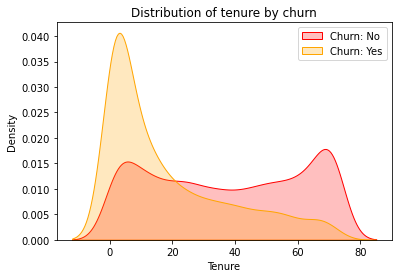

In [14]:
# Tenure
T = sns.kdeplot(telco_churn_df_pd[telco_churn_df_pd['Churn'] == 'No']['tenure'].dropna(),label= 'Churn: No', color="Red", shade = True)
T = sns.kdeplot(telco_churn_df_pd[telco_churn_df_pd['Churn'] == 'Yes']['tenure'].dropna(),label= 'Churn: Yes', color="Orange", shade = True)
T.set_ylabel('Density')
T.set_xlabel('Tenure')
T.set_title('Distribution of tenure by churn')
T.legend()

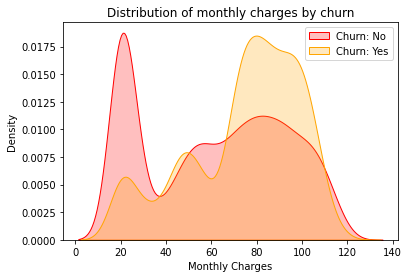

In [15]:
# MonthlyCharges
MC = sns.kdeplot(telco_churn_df_pd[telco_churn_df_pd['Churn'] == 'No']['MonthlyCharges'].dropna(), color= 'Red', label= 'Churn: No', shade = True)
MC = sns.kdeplot(telco_churn_df_pd[telco_churn_df_pd['Churn'] == 'Yes']['MonthlyCharges'].dropna(), color= 'Orange', label= 'Churn: Yes', shade = True)
MC.set_ylabel('Density')
MC.set_xlabel('Monthly Charges')
MC.set_title('Distribution of monthly charges by churn')
MC.legend()

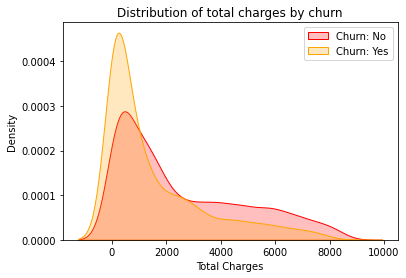

In [16]:
# TotalCharges
TC = sns.kdeplot(telco_churn_df_pd[telco_churn_df_pd['Churn'] == 'No']['TotalCharges'].dropna(), color= 'Red', label= 'Churn: No', shade = True)
TC = sns.kdeplot(telco_churn_df_pd[telco_churn_df_pd['Churn'] == 'Yes']['TotalCharges'].dropna(), color= 'Orange', label= 'Churn: Yes', shade = True)
TC.set_ylabel('Density')
TC.set_xlabel('Total Charges')
TC.set_title('Distribution of total charges by churn')
TC.legend()

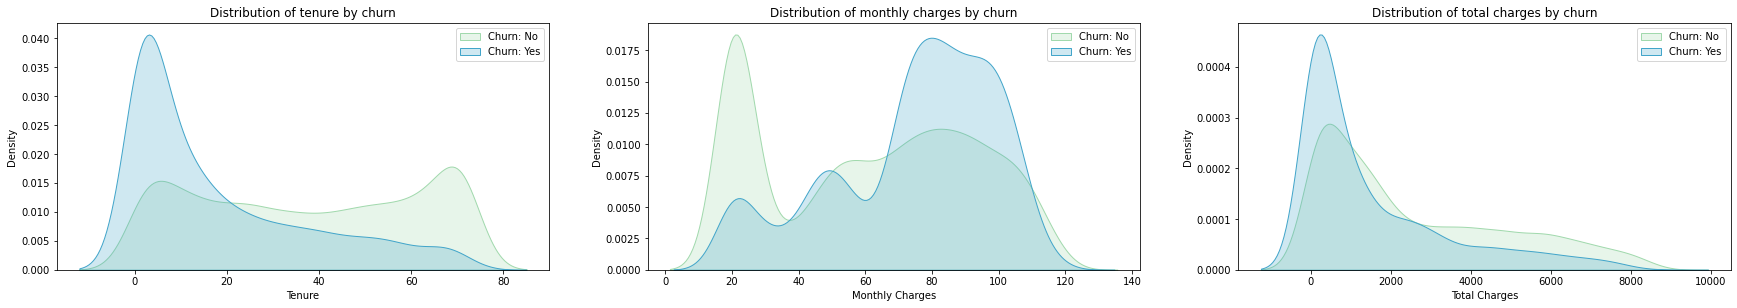

In [17]:
plt.figure(figsize=(30, 10))
plt.subplot(2, 3, 1)
T = sns.kdeplot(telco_churn_df_pd[telco_churn_df_pd['Churn'] == 'No']['tenure'].dropna(),label= 'Churn: No', color='#A1D9AD',  shade = True)
T = sns.kdeplot(telco_churn_df_pd[telco_churn_df_pd['Churn'] == 'Yes']['tenure'].dropna(),label= 'Churn: Yes', color='#42A5CA', shade = True)
T.set_ylabel('Density')
T.set_xlabel('Tenure')
T.set_title('Distribution of tenure by churn')
T.legend()

plt.subplot(2, 3, 2)
# MonthlyCharges
MC = sns.kdeplot(telco_churn_df_pd[telco_churn_df_pd['Churn'] == 'No']['MonthlyCharges'].dropna(), color= '#A1D9AD', label= 'Churn: No', shade = True)
MC = sns.kdeplot(telco_churn_df_pd[telco_churn_df_pd['Churn'] == 'Yes']['MonthlyCharges'].dropna(), color= '#42A5CA', label= 'Churn: Yes', shade = True)
MC.set_ylabel('Density')
MC.set_xlabel('Monthly Charges')
MC.set_title('Distribution of monthly charges by churn')
MC.legend()

plt.subplot(2, 3, 3)
# TotalCharges
TC = sns.kdeplot(telco_churn_df_pd[telco_churn_df_pd['Churn'] == 'No']['TotalCharges'].dropna(), color= '#A1D9AD', label= 'Churn: No', shade = True)
TC = sns.kdeplot(telco_churn_df_pd[telco_churn_df_pd['Churn'] == 'Yes']['TotalCharges'].dropna(), color= '#42A5CA', label= 'Churn: Yes', shade = True)
TC.set_ylabel('Density')
TC.set_xlabel('Total Charges')
TC.set_title('Distribution of total charges by churn')
TC.legend()

plt.show()

Text(0.5, 1.0, 'Correlation heatmap')

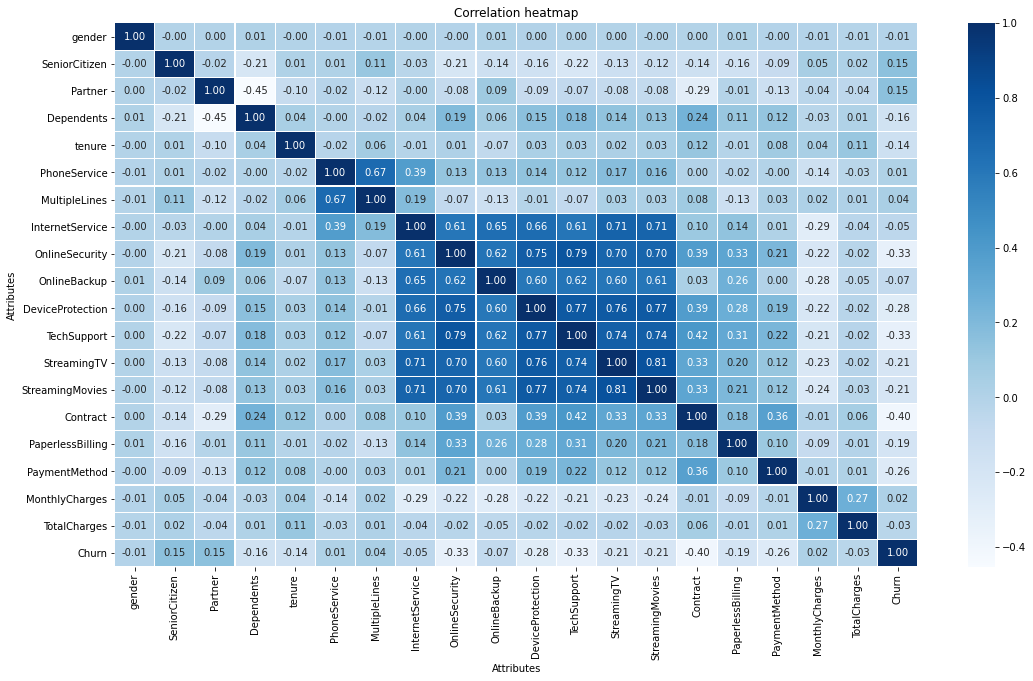

In [18]:
import pandas as pd
plt.figure(figsize=(18, 10))
H = sns.heatmap(telco_churn_df_pd.
                apply(lambda x: pd.factorize(x)[0]).corr(), 
                annot=True,
                fmt=".2f", 
                xticklabels=telco_churn_df_pd.apply(lambda x: pd.factorize(x)[0]).corr().columns, 
                yticklabels=telco_churn_df_pd.apply(lambda x: pd.factorize(x)[0]).corr().columns, 
                linewidths=.1, cmap="Blues")
H.set_ylabel('Attributes')
H.set_xlabel('Attributes')
H.set_title('Correlation heatmap')


## Categorical Variables

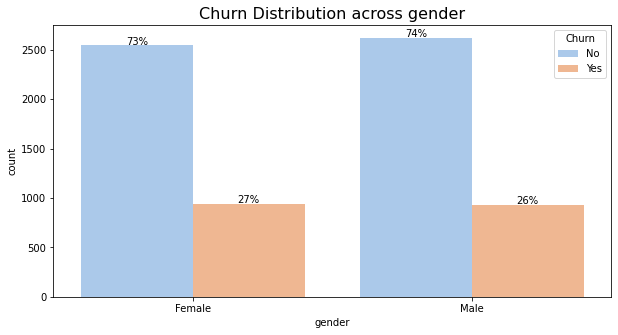

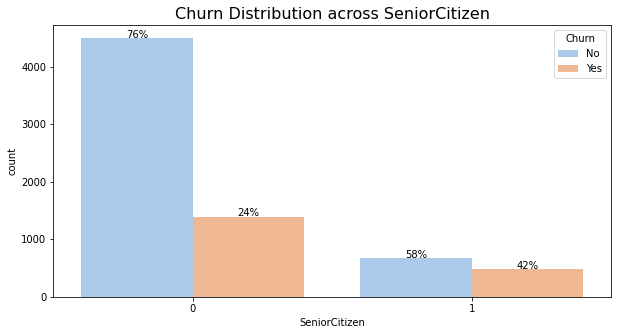

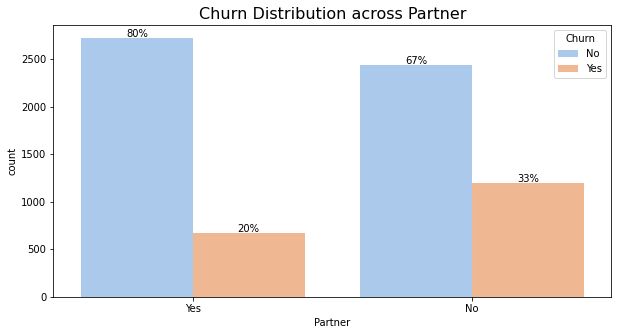

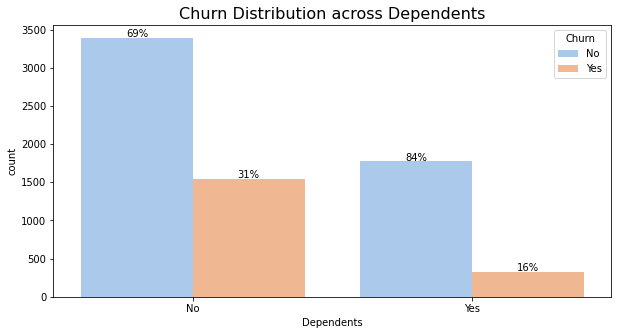

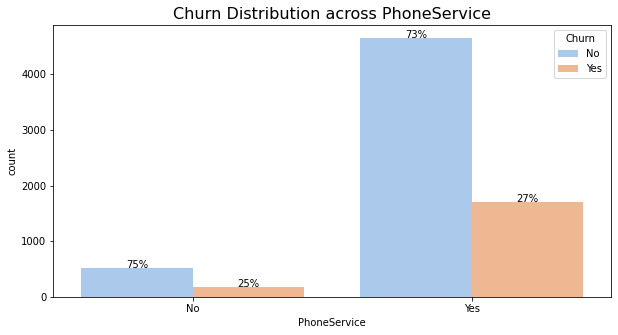

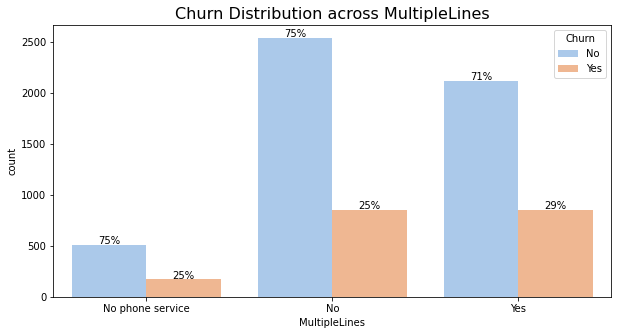

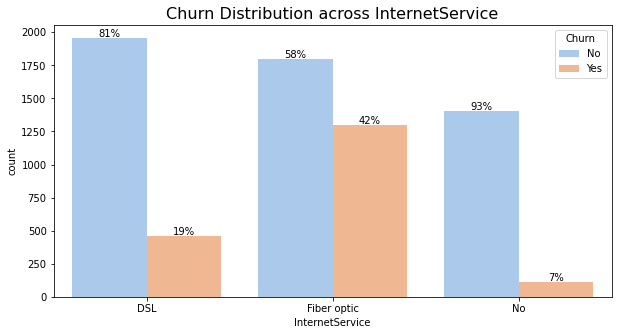

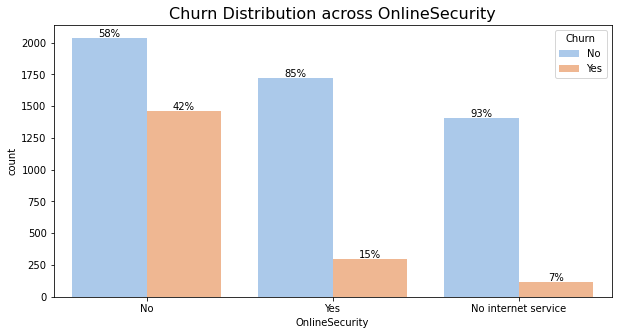

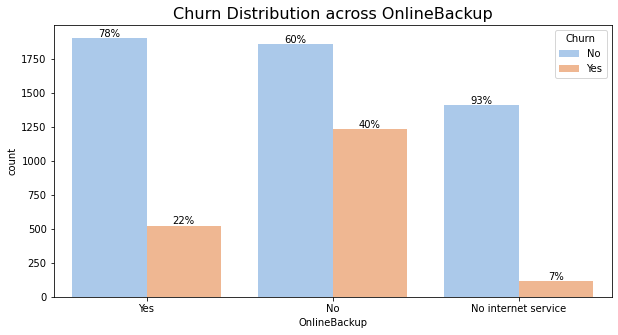

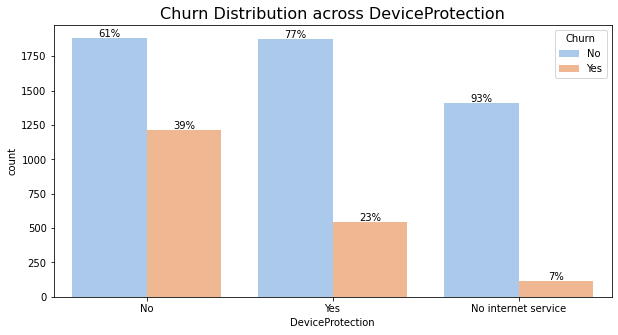

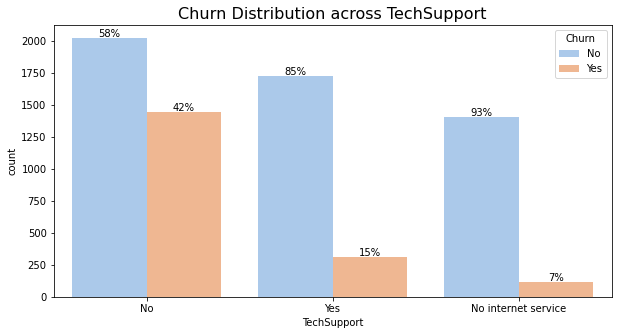

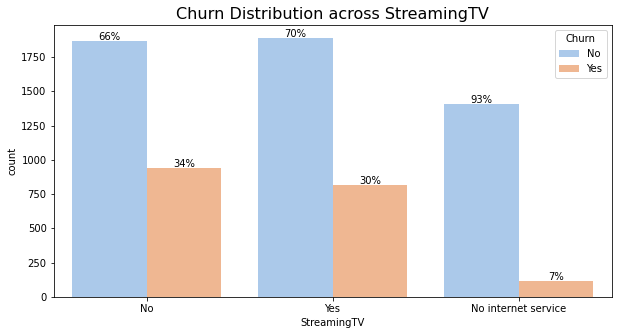

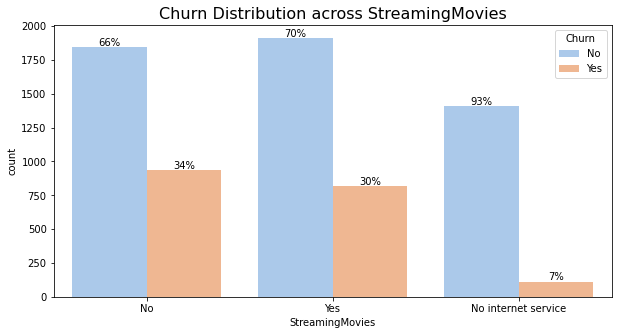

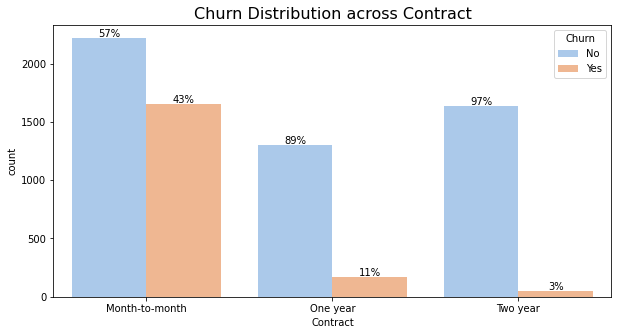

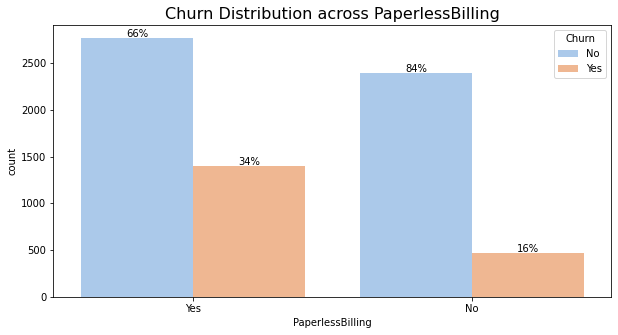

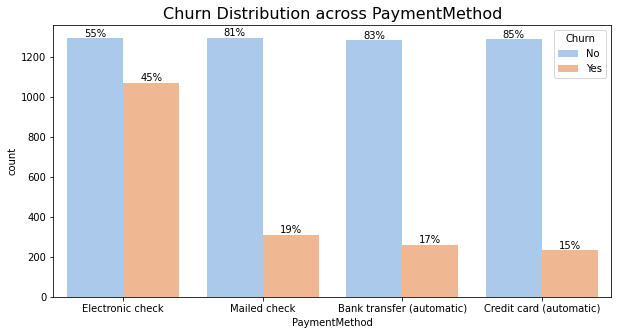

In [19]:
# plot categorical variables vs. churn

for col in cat_vars:

    plt.figure(figsize = (10, 5))
    ax = sns.countplot(x = col, hue = 'Churn', data = telco_churn_df_pd, palette = "pastel")
    ax.set_title("Churn Distribution across {}".format(col), fontsize = 16)
    
    bars = ax.patches
    half = int(len(bars)/2)
    left_bars = bars[:half]
    right_bars = bars[half:]

    for left, right in zip(left_bars, right_bars):
        height_l = left.get_height()
        height_r = right.get_height()
        total = height_l + height_r

        ax.text(left.get_x() + left.get_width()/2., height_l + 10, '{0:.0%}'.format(height_l/total), ha="center")
        ax.text(right.get_x() + right.get_width()/2., height_r + 10, '{0:.0%}'.format(height_r/total), ha="center")

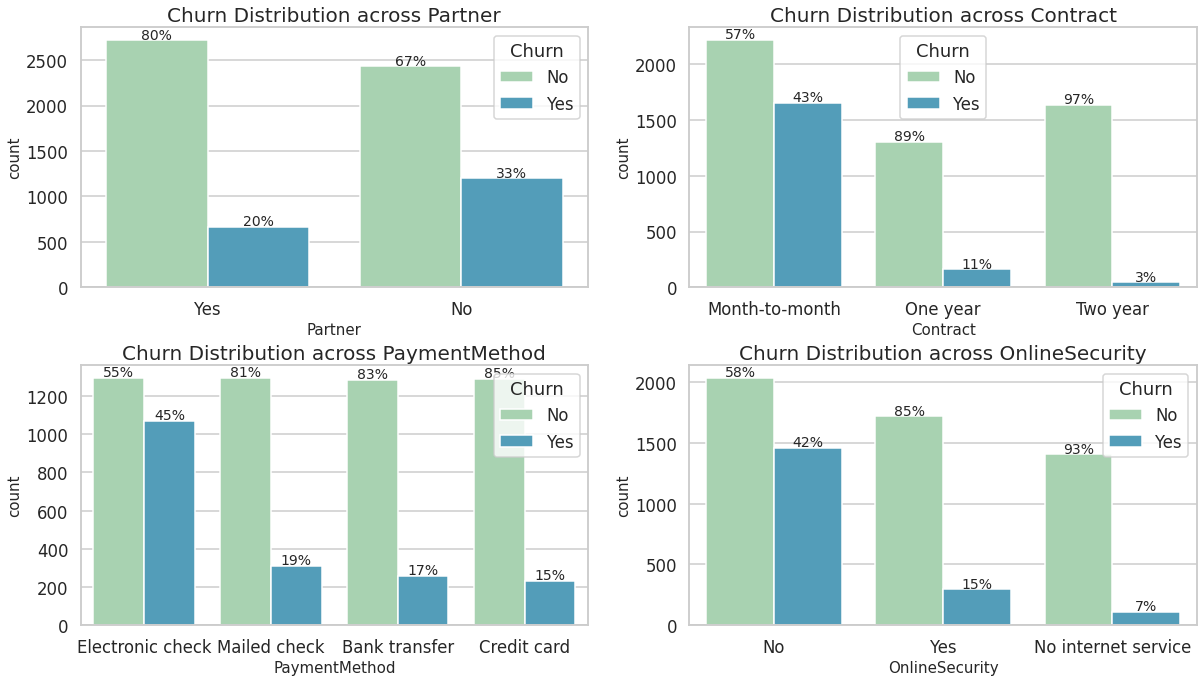

In [20]:
telco_churn_df_pd['PaymentMethod'] = telco_churn_df_pd['PaymentMethod'].replace(['Credit card (automatic)'],'Credit card')
telco_churn_df_pd['PaymentMethod'] = telco_churn_df_pd['PaymentMethod'].replace(['Bank transfer (automatic)'],'Bank transfer')

sns.set(style = 'whitegrid', rc = {"grid.linewidth": 0.1})
sns.set_context("talk", rc = {"font.size":12, "axes.titlesize":20, "axes.labelsize":15}) 

cat_vars_2 = ['Partner', 'Contract', 'PaymentMethod', 'OnlineSecurity']

fig = plt.figure(figsize=(20, 11))
plt.subplots_adjust(hspace = 0.3)

for col, i in zip(cat_vars_2, range(1,5)):
    
    ax = fig.add_subplot(2,2,i)
    sns.countplot(x = col, hue = 'Churn', data = telco_churn_df_pd, palette = ['#A1D9AD', '#42A5CA'])
    ax.set_title("Churn Distribution across {}".format(col), fontsize = 20)
    
    bars = ax.patches
    half = int(len(bars)/2)
    left_bars = bars[:half]
    right_bars = bars[half:]

    for left, right in zip(left_bars, right_bars):
        height_l = left.get_height()
        height_r = right.get_height()
        total = height_l + height_r

        ax.text(left.get_x() + left.get_width()/2., height_l + 10, '{0:.0%}'.format(height_l/total), ha="center", fontsize = 14)
        ax.text(right.get_x() + right.get_width()/2., height_r + 10, '{0:.0%}'.format(height_r/total), ha="center", fontsize = 14)

plt.show()

# ML Models


## Data Transformation

In [21]:
bi_var = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
tri_var = list(set(cat_vars) - set(bi_var))

# indexing binary variables: male = 1, yes = 1
indexers = [StringIndexer(inputCol=column, outputCol=column+"_idx", stringOrderType = 'alphabetAsc').fit(telco_churn_df) for column in bi_var]
pipeline = Pipeline(stages=indexers)
df_transform = pipeline.fit(telco_churn_df).transform(telco_churn_df)

indexers = [StringIndexer(inputCol='Churn', outputCol="label", stringOrderType = 'alphabetAsc')]
pipeline = Pipeline(stages=indexers)
df_transform = pipeline.fit(df_transform).transform(df_transform)


# get the distinct values of each categorical column
pm_list = ['Credit card (automatic)', 'Mailed check', 'Bank transfer (automatic)', 'Electronic check']
ml_list = ['Yes', 'No', 'No phone service']
con_list = ['Month-to-month', 'One year', 'Two year']
common_list = ['Yes', 'No', 'No internet service']
is_list = ['No', 'Fiber optic', 'DSL']
# To convert the three categorical data into ordinal numeric data, we need to define the StringIndexerModel pipeline respectively
stage_1 = StringIndexerModel.from_labels(common_list, inputCol="TechSupport", outputCol="TechSupport_idx")
stage_2 = StringIndexerModel.from_labels(pm_list, inputCol="PaymentMethod", outputCol="PaymentMethod_idx")
stage_3 = StringIndexerModel.from_labels(ml_list, inputCol="MultipleLines", outputCol="MultipleLines_idx")
stage_4 = StringIndexerModel.from_labels(common_list, inputCol="StreamingTV", outputCol="StreamingTV_idx")
stage_5 = StringIndexerModel.from_labels(common_list, inputCol="OnlineBackup", outputCol="OnlineBackup_idx")
stage_6 = StringIndexerModel.from_labels(common_list, inputCol="DeviceProtection", outputCol="DeviceProtection_idx")
stage_7 = StringIndexerModel.from_labels(common_list, inputCol="StreamingMovies", outputCol="StreamingMovies_idx")
stage_8 = StringIndexerModel.from_labels(con_list, inputCol="Contract", outputCol="Contract_idx")
stage_9 = StringIndexerModel.from_labels(is_list, inputCol="InternetService", outputCol="InternetService_idx")
stage_10 = StringIndexerModel.from_labels(common_list, inputCol="OnlineSecurity", outputCol="OnlineSecurity_idx")

# combine and encapsulate all the transformation codes into one pipeline
feature_engineering_pipe = Pipeline(stages=[stage_1, stage_2, stage_3, stage_4, stage_5, 
                                            stage_6, stage_7, stage_8, stage_9, stage_10])
result = feature_engineering_pipe.fit(df_transform).transform(df_transform)

result = result.drop(*bi_var)
result = result.drop(*tri_var)
result = result.drop('Churn')
df_transform = result.toDF(*(c.replace('_idx', '') for c in result.columns))

encoders = [OneHotEncoder(inputCol=column, outputCol=column+"_encoded").fit(df_transform) for column in tri_var]
pipeline = Pipeline(stages=encoders)
df_encode = pipeline.fit(df_transform).transform(df_transform)

df_encode = df_encode.drop(*tri_var)
df_encode = df_encode.toDF(*(c.replace('_encoded', '') for c in df_encode.columns))

featname_encode = ['tenure', 'MonthlyCharges', 'TotalCharges', 'gender_male', 'SeniorCitizen', 'Partner',
                   'Dependents', 'PhoneService', 'PaperlessBilling', 'OnlineSecurity_yes', 'OnlineSecurity_no',
                   'TechSupport_yes', 'TechSupport_no', 'Contract_month', 'Contract_1year',
                   'MultipleLines_yes', 'MultipleLines_no', 'InternetService_no', 'InternetService_fiber', 
                   'OnlineBackup_yes', 'OnlineBackup_no', 'StreamingTV_yes', 'StreamingTV_no',
                   'StreamingMovies_yes', 'StreamingMovies_no', 'DeviceProtection_yes', 'DeviceProtection_no',
                   'PaymentMethod_credit', 'PaymentMethod_mail', 'PaymentMethod_bank']

prepro_pipe = Pipeline(stages=[VectorAssembler(inputCols=df_encode.drop('label').columns, outputCol='vec_features'),
                               StandardScaler(withMean=True, withStd = True, inputCol='vec_features', outputCol='zfeatures')])
fitted = prepro_pipe.fit(df_encode)
fitted_df = fitted.transform(df_encode)

## Logistic Regression

### Imbalancing handling
Their is imbalance in the dataset. Thankfully, in the case of logistic regression we have a technique called “Class Weighing”. 

In [22]:
train, test = fitted_df.randomSplit([0.7, 0.3], )
evaluator = BinaryClassificationEvaluator()

fitted_df_pd = fitted_df.toPandas()
BalancingRatio= len(fitted_df_pd[fitted_df_pd['label'] == 0])/len(fitted_df_pd['label'])
print('BalancingRatio = {}'.format(BalancingRatio))

train = train.withColumn("classWeights", when(train.label == 1,BalancingRatio).otherwise(1-BalancingRatio))
train.select("classWeights").show(5)

BalancingRatio = 0.7342150170648464
+------------------+
|      classWeights|
+------------------+
|0.2657849829351536|
|0.2657849829351536|
|0.2657849829351536|
|0.2657849829351536|
|0.2657849829351536|
+------------------+
only showing top 5 rows



### Grid Search

In [23]:
lr = LogisticRegression(labelCol="label", featuresCol="zfeatures", weightCol="classWeights")

if grid_search:
    
    # generate the grid object, which iterates over different combinations of paramters
    lrparamGrid = (ParamGridBuilder()\
                   .addGrid(lr.elasticNetParam, [0.5, 0.2, 0.1, 0.3])\
                   .addGrid(lr.regParam, [0.01, 0.02, 0.1, 0.5])\
                   .build())

    # generate a 3-fold cross validation model
    lrcv = CrossValidator(estimator = lr,
                          estimatorParamMaps = lrparamGrid,
                          evaluator = evaluator,
                          numFolds = 3)

    lr_cvModel = lrcv.fit(train)

    print('elasticNetParam - ', lr_cvModel.bestModel.getOrDefault('elasticNetParam'))
    print('regParam - ', lr_cvModel.bestModel.getOrDefault('regParam'))
    
    pass

### Best Model

Text(0, 0.5, 'Features')

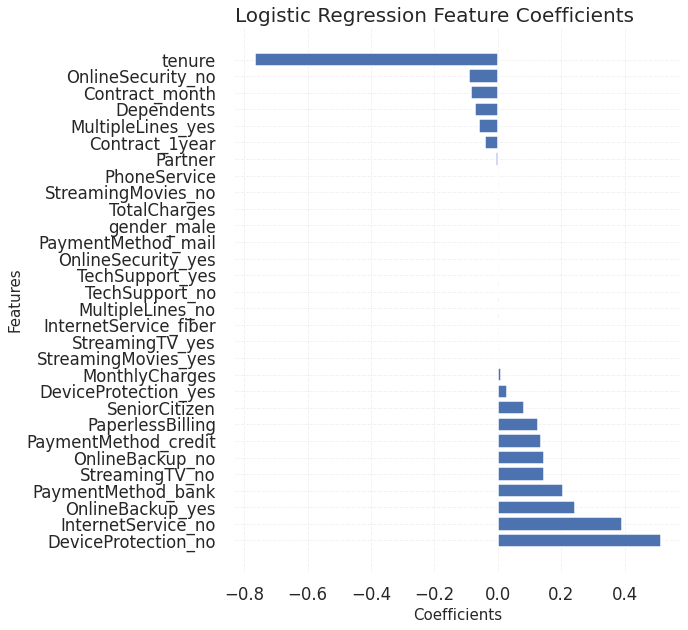

In [24]:
# Best Model
lr_pipe = Pipeline(stages = [LogisticRegression(labelCol="label", featuresCol="zfeatures", weightCol="classWeights")\
                             .setRegParam(0.01)\
                             .setElasticNetParam(0.5)])
lr_best = lr_pipe.fit(train)

predictions = lr_best.transform(test)


# Feature importance
lr_feat = pd.DataFrame({'Feature': featname_encode,
                        'Coefficients': lr_best.stages[0].coefficients.toArray()}).sort_values('Coefficients', ascending = False) 
                       
# Plotting
fig, ax = plt.subplots(figsize =(8, 10))  
ax.barh(lr_feat['Feature'], lr_feat['Coefficients']) 

# Remove axes splines 
for s in ['top', 'bottom', 'left', 'right']: 
    ax.spines[s].set_visible(False) 
  
# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
  
# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10) 
  
# Add x, y gridlines 
ax.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.5, 
        alpha = 0.2)

ax.set_title('Logistic Regression Feature Coefficients', loc ='left', ) 

ax.set_xlabel("Coefficients")
ax.set_ylabel("Features")

### Result Evaluation

In [25]:
def result_evaluate(predictions):
  preds_and_labels = predictions.select(['prediction','label']).orderBy('prediction')
  metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
  confuse = metrics.confusionMatrix().toArray()
  print('Test Accuracy - ', metrics.accuracy)
  print('Test Recall - ', confuse[0][0]/(confuse[0][0] + confuse[1][0]))
  print('Test Precision - ', confuse[0][0]/(confuse[0][0] + confuse[0][1]))
  print('Test F1 - ', 2*confuse[0][0]/(2*confuse[0][0] + confuse[0][1] + confuse[1][0]))
  evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
  print('Test Area Under ROC - ', evaluator.evaluate(predictions))
  evaluator = BinaryClassificationEvaluator(metricName="areaUnderPR")
  print('Test Area under PR - ', evaluator.evaluate(predictions))

In [26]:
result_evaluate(predictions)

Test Accuracy -  0.7497639282341831
Test Recall -  0.8926868044515104
Test Precision -  0.7397891963109354
Test F1 -  0.8090778097982709
Test Area Under ROC -  0.8372326526130861
Test Area under PR -  0.6665617725575288


## SVM

### Grid Search

In [27]:
svm = LinearSVC(labelCol="label", featuresCol="zfeatures", weightCol="classWeights")

if grid_search: 
    # generate the grid object, which iterates over different combinations of paramters
    SVMparamGrid = (ParamGridBuilder()\
                    .addGrid(svm.threshold, [0.2, 0.5, 0.7])\
                    .addGrid(svm.regParam, [0.5, 0.01, 0.1])\
                    .build())

    # generate a 3-fold cross validation model
    svm_cv = CrossValidator(estimator = svm,
                            estimatorParamMaps = SVMparamGrid,
                            evaluator = evaluator,
                            numFolds = 3)

    svm_cvModel = svm_cv.fit(train)

    print('threshold - ', svm_cvModel.bestModel.getOrDefault('threshold'))
    print('regParam - ', svm_cvModel.bestModel.getOrDefault('regParam'))
    
    pass

### Best Model

Text(0, 0.5, 'Features')

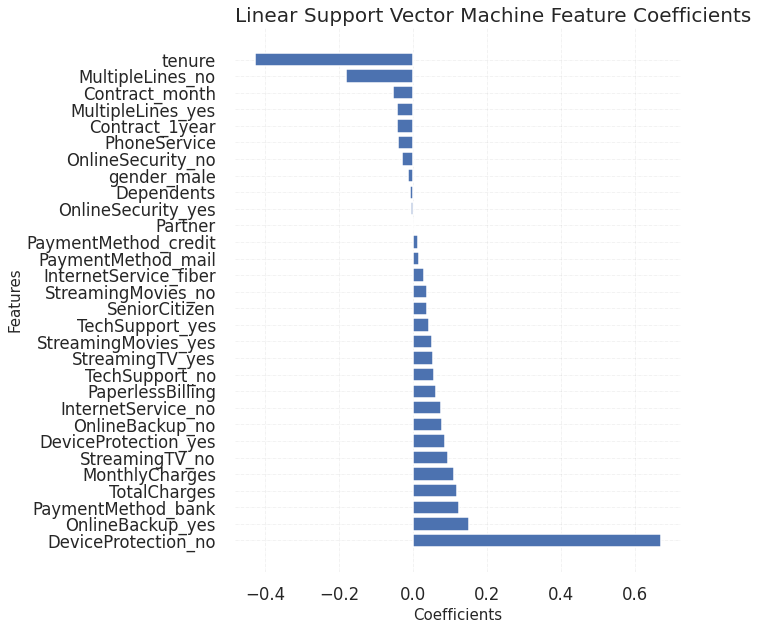

In [28]:
# Best Model
svm_pipe = Pipeline(stages = [LinearSVC(labelCol="label", featuresCol="zfeatures", weightCol="classWeights")\
                              .setRegParam(0.01).setThreshold(0.2)])
svm_best = svm_pipe.fit(train)

predictions = svm_best.transform(test)

# Feature importance
svm_feat = pd.DataFrame({'Feature': featname_encode,
                        'Coefficients': svm_best.stages[0].coefficients.toArray()}).sort_values('Coefficients', ascending = False) 
                       
# Plotting
fig, ax = plt.subplots(figsize =(8, 10))  
ax.barh(svm_feat['Feature'], svm_feat['Coefficients']) 

# Remove axes splines 
for s in ['top', 'bottom', 'left', 'right']: 
    ax.spines[s].set_visible(False) 
  
# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
  
# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10) 
  
# Add x, y gridlines 
ax.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.5, 
        alpha = 0.2)

ax.set_title('Linear Support Vector Machine Feature Coefficients', loc ='left', ) 

ax.set_xlabel("Coefficients")
ax.set_ylabel("Features")

### Result Evaluation

In [29]:
result_evaluate(predictions)

Test Accuracy -  0.7252124645892352
Test Recall -  0.9041450777202072
Test Precision -  0.6897233201581028
Test F1 -  0.7825112107623319
Test Area Under ROC -  0.8390294246815977
Test Area under PR -  0.6710453997924452


## Random Forest

### Grid Search

In [30]:

if grid_search:
    
    rf = RandomForestClassifier(labelCol="label", featuresCol="zfeatures", weightCol="classWeights")

    paramGrid = (ParamGridBuilder()\
                 .addGrid(rf.maxDepth, [10, 15, 20])\
                 .addGrid(rf.numTrees, [10, 15, 20, 30])\
                 .build())

    rf_cv = CrossValidator(estimator=rf, 
                           estimatorParamMaps=paramGrid, 
                           evaluator=evaluator,
                           numFolds = 3)

    rf_Model = rf_cv.fit(train)

    print('numTrees - ', rf_Model.bestModel.getNumTrees)
    print('maxDepth - ', rf_Model.bestModel.getOrDefault('maxDepth'))
    
    pass

### Best Model

Text(0, 0.5, 'Features')

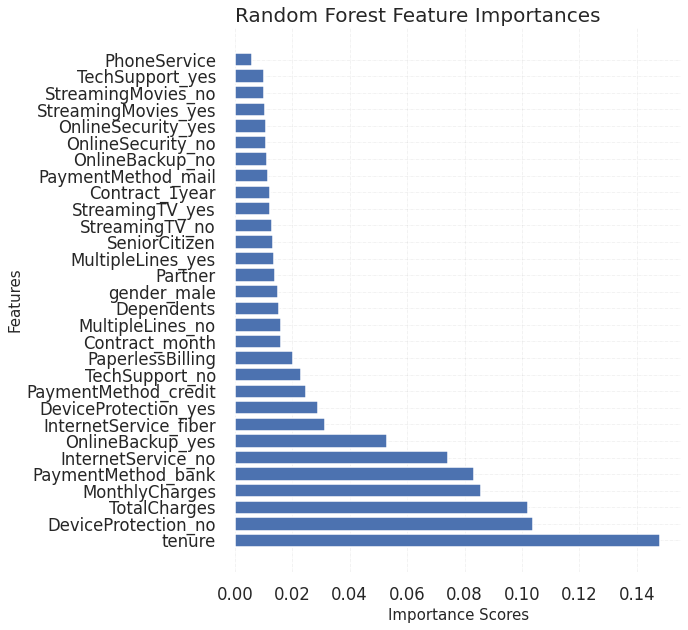

In [31]:
# Best Model
rf_pipe = Pipeline(stages = [RandomForestClassifier(labelCol = 'label', featuresCol = 'zfeatures', weightCol="classWeights")\
                             .setNumTrees(30)\
                             .setMaxDepth(10)])
rf_best = rf_pipe.fit(train)

predictions = rf_best.transform(test)
    
# Feature importance
rf_feat = pd.DataFrame({'Feature': featname_encode,
                        'Importance_score': rf_best.stages[0].featureImportances}).sort_values('Importance_score', ascending = False) 
                       
# Plotting
fig, ax = plt.subplots(figsize =(8, 10))  
ax.barh(rf_feat['Feature'], rf_feat['Importance_score']) 

# Remove axes splines 
for s in ['top', 'bottom', 'left', 'right']: 
    ax.spines[s].set_visible(False) 
    
# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
  
# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10) 
  
# Add x, y gridlines 
ax.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.5, 
        alpha = 0.2)

ax.set_title('Random Forest Feature Importances', loc ='left', ) 

ax.set_xlabel("Importance Scores")
ax.set_ylabel("Features")

### Result Evaluation

In [32]:
result_evaluate(predictions)

Test Accuracy -  0.7813975448536356
Test Recall -  0.8712174524982407
Test Precision -  0.8155467720685112
Test F1 -  0.8424634229329704
Test Area Under ROC -  0.8401257136583219
Test Area under PR -  0.6760961931656769


## Gradient Boosting

### Grid Search

In [33]:
# GBT tuning

if grid_search:
    gbt = GBTClassifier(labelCol = 'label', featuresCol = 'zfeatures', weightCol="classWeights").setMaxIter(50)

    # generate the grid object, which iterates over different combinations of paramters
    gbt_paramGrid = (ParamGridBuilder()\
                     .addGrid(gbt.maxDepth, [2, 4, 6, 8])\
                     #.addGrid(gbt.maxIter, [50, 100, 150, 200])\
                     .addGrid(gbt.maxBins, [20, 30, 50])
                     .build())

    # generate a 3-fold cross validation model
    gbt_cv = CrossValidator(estimator = gbt,
                            estimatorParamMaps = gbt_paramGrid,
                            evaluator = evaluator,
                            numFolds = 3)

    gbtModel = gbt_cv.fit(train)

    print('maxBins - ', gbtModel.bestModel.getOrDefault('maxBins'))
    print('maxIter - ', gbtModel.bestModel.getOrDefault('maxIter'))
    print('maxDepth - ', gbtModel.bestModel.getOrDefault('maxDepth'))
    
    pass

### Best Model

Text(0, 0.5, 'Features')

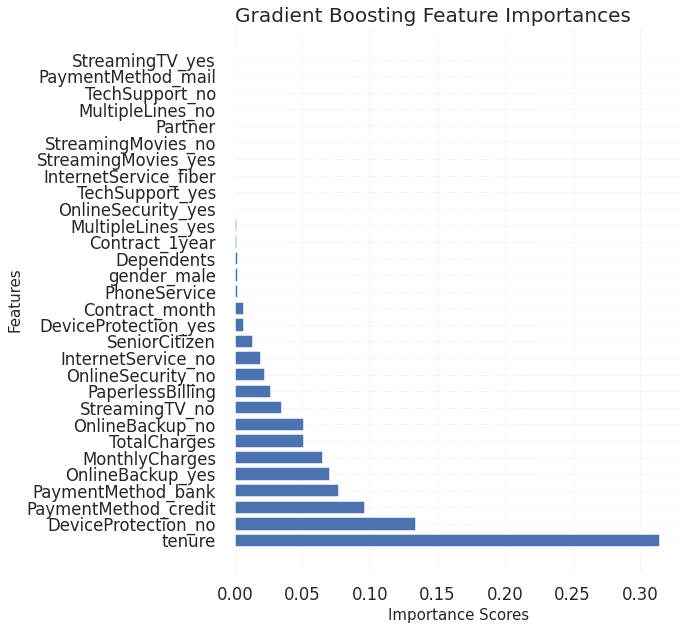

In [34]:
# Best model
gbt_pipe = Pipeline(stages = [GBTClassifier(labelCol = 'label', featuresCol = 'zfeatures', weightCol="classWeights")\
                             .setMaxDepth(2).setMaxIter(50).setMaxBins(30)])
gbt_best = gbt_pipe.fit(train)

predictions = gbt_best.transform(test)

# Feature importance
gbt_feat = pd.DataFrame({'Feature': featname_encode,
                         'Importance_score': gbt_best.stages[0].featureImportances}).sort_values('Importance_score', ascending = False) 

fig, ax = plt.subplots(figsize =(8, 10))  
ax.barh(gbt_feat['Feature'], gbt_feat['Importance_score']) 

# Remove axes splines 
for s in ['top', 'bottom', 'left', 'right']: 
    ax.spines[s].set_visible(False) 
  
# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
  
# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10) 
  
# Add x, y gridlines 
ax.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.5, 
        alpha = 0.2)

ax.set_title('Gradient Boosting Feature Importances', loc ='left', ) 

ax.set_xlabel("Importance Scores")
ax.set_ylabel("Features")              

### Result Evaluation

In [35]:
result_evaluate(predictions)

Test Accuracy -  0.7634560906515581
Test Recall -  0.9000786782061369
Test Precision -  0.7536231884057971
Test F1 -  0.820365722481176
Test Area Under ROC -  0.8412906236275767
Test Area under PR -  0.6776050065743893


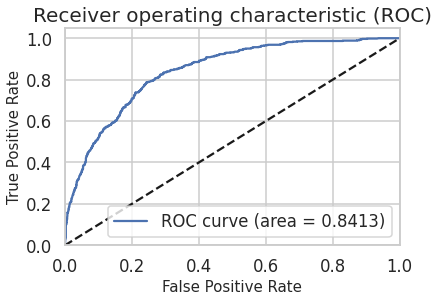

In [36]:

preds = predictions.select('label', 'probability')\
                   .rdd.map(lambda row: (float(row['probability'][1]), float(row['label']))).collect()

y_score, y_true = zip(*preds)
fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label = 1)
roc_auc = auc(fpr, tpr)  

# visualization
plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc = "lower right")
plt.show()

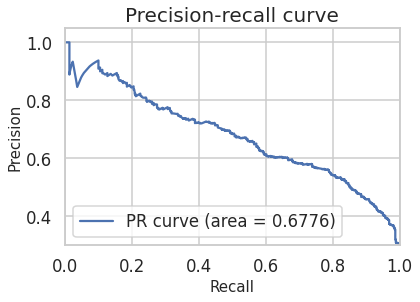

In [37]:

precision, recall, thresholds = precision_recall_curve(y_true, y_score, pos_label = 1)
pr_auc = auc(recall, precision)

# visualization
plt.figure()
plt.plot(recall, precision, label = 'PR curve (area = %0.4f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.3, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve')
plt.legend(loc = "lower left")
plt.show()

## K-Means

In [38]:
#PCA
pca = feature.PCA(k=10, inputCol='zfeatures', outputCol='scores')
pipe_pca = Pipeline(stages=[pca]).fit(train)
pipe_pca_df = pipe_pca.transform(test)

Text(0, 0.5, 'Proportion Variance Explained')

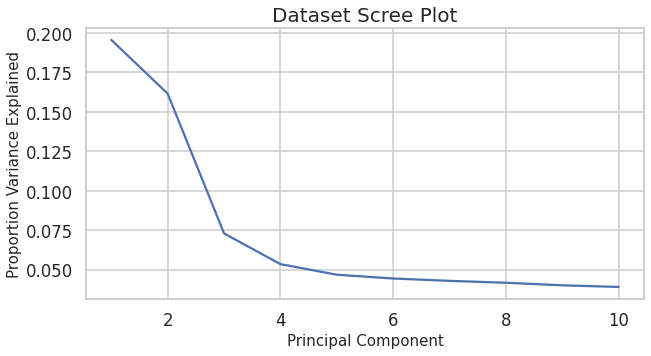

In [39]:
plt.figure(figsize = (10, 5))
explained_var = pipe_pca.stages[0].explainedVariance
plt.plot(np.arange(1, len(explained_var)+1), explained_var)
plt.title("Dataset Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance Explained")

Text(0, 0.5, 'Cumulative Sum of Variance Explained')

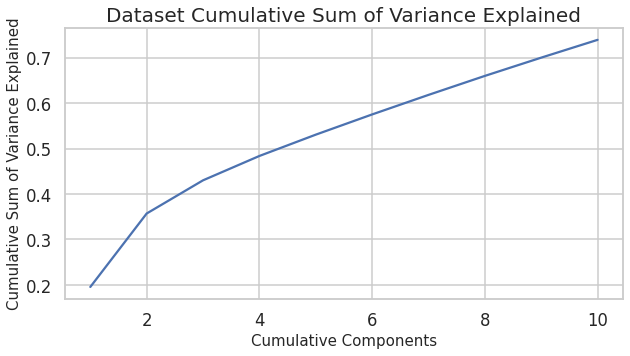

In [40]:
cum_sum = np.cumsum(explained_var)
plt.figure(figsize = (10, 5))
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.title("Dataset Cumulative Sum of Variance Explained")
plt.xlabel("Cumulative Components")
plt.ylabel("Cumulative Sum of Variance Explained")

In [41]:
if grid_search:
  ls = []

  for a in range(2,7):
    kmeans = clustering.KMeans(k=a, featuresCol='zfeatures', predictionCol='kmean-feat')
    model_km = Pipeline(stages = [pca,kmeans]).fit(train)
    predictions = model_km.transform(test)
    evaluator = ClusteringEvaluator().setFeaturesCol("scores").setPredictionCol("kmean-feat").setMetricName('silhouette')
    silhouette = evaluator.evaluate(predictions)
    ls.append(silhouette)

    pass

In [42]:
if grid_search:
  plot_df = pd.DataFrame(data = {"k": range(2,7), 'silhouette': ls})

  plt.figure()
  plt.plot(range(2,7), ls)
  plt.title("K vs silhouette Plot")
  plt.xlabel("K")
  plt.ylabel("Silhouette")

  pass

### Best Model

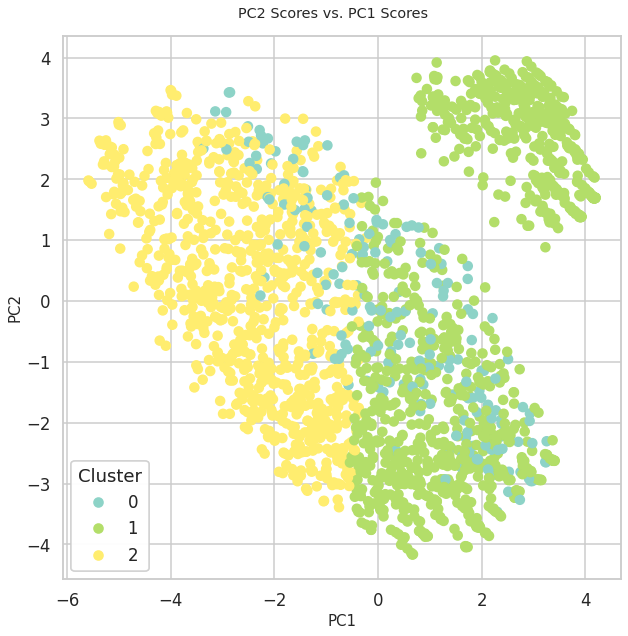

None

In [49]:
# Best Model
km_pipe = Pipeline(stages = [pca, KMeans(k = 3, predictionCol='kmean-feat', featuresCol = 'zfeatures')])
km_best = km_pipe.fit(train)
km_best_df = km_best.transform(test)

X = np.array(km_best_df.select('scores').rdd.map(lambda x: x['scores']).collect())

k = np.array(km_best_df.select('kmean-feat').rdd.map(lambda x: x['kmean-feat']).collect())

label_c = np.array(km_best_df.select('OnlineSecurity').rdd.map(lambda x: x['OnlineSecurity']).collect())


fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
scatter = ax.scatter(X[:,0], X[:,1], c = k, cmap = 'Set3')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Cluster")
ax.add_artist(legend1)

fig.suptitle("PC2 Scores vs. PC1 Scores", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

# for i, txt in enumerate(label_c):
#           ax.annotate(txt, (X[i,0], X[i,1]), fontsize = 12, alpha=0.5)
    
display(plt.show())


In [50]:
compare_feat = pd.merge(rf_feat, gbt_feat, on = 'Feature', how = 'left')
compare_feat = pd.merge(compare_feat, lr_feat, on = 'Feature', how = 'left')
compare_feat = pd.merge(compare_feat, svm_feat, on = 'Feature', how = 'left')
compare_feat.columns = ['Feature', 'RF_importance_score', 'GBT_importance_score', 'LR_coefficient', 'SVM_coefficient']
compare_feat

,Feature,RF_importance_score,GBT_importance_score,LR_coefficient,SVM_coefficient
0,tenure,0.148152,0.314787,-0.765180,-0.427484
1,DeviceProtection_no,0.103796,0.133692,0.515021,0.669629
2,TotalCharges,0.102037,0.051365,0.000000,0.118601
3,MonthlyCharges,0.085892,0.064838,0.009121,0.110151
4,PaymentMethod_bank,0.083249,0.077235,0.207009,0.124528
5,InternetService_no,0.074211,0.019533,0.392158,0.073778
6,OnlineBackup_yes,0.053095,0.070198,0.243345,0.149142
7,InternetService_fiber,0.031407,0.000000,0.000000,0.028591
8,DeviceProtection_yes,0.028906,0.007070,0.028754,0.086505
9,PaymentMethod_credit,0.024681,0.096574,0.136613,0.013034
